# Criação do Modelo de Classificação de Gênero Musical 

Carregando pacotes:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import codecs
import re
import string
import numpy as np

from nltk.stem import RSLPStemmer             
from nltk.tokenize import TweetTokenizer   
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import model_selection

import nltk 
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\lucca\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

## 1. Carregando Dados

In [2]:
bossa_nova_df = pd.read_csv("data/bossa_nova.csv")
funk_df = pd.read_csv("data/funk.csv")
gospel_df = pd.read_csv("data/gospel.csv")
sertanejo_df = pd.read_csv("data/sertanejo.csv")

### 1.1 Carregando cojunto de stop words para limpeza do texto:

In [3]:
with codecs.open('data/stopwords.txt', encoding="utf-8") as file:
    stop_words = file.readlines()

stop_words = [word.strip() for word in stop_words]
stop_words

['de',
 'a',
 'o',
 'que',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'é',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'foi',
 'ao',
 'ele',
 'das',
 'tem',
 'à',
 'seu',
 'sua',
 'ou',
 'ser',
 'quando',
 'muito',
 'há',
 'nos',
 'já',
 'está',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'era',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'ter',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'estão',
 'você',
 'tinha',
 'foram',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'têm',
 'numa',
 'pelos',
 'elas',
 'havia',
 'seja',
 'qual',
 'será',
 'nós',
 'tenho',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'fosse',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo

## 2. Tratamento dos Dados

### 2.1 Tokenizando as letras das músicas para retirada das stop words e pontuação e realizar a stemização

In [4]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,reduce_len=True)

In [5]:
all_tokens_bossa = [tokenizer.tokenize(lyric) for lyric in bossa_nova_df["lyric"].values]
all_tokens_funk = [tokenizer.tokenize(lyric) for lyric in funk_df["lyric"].values]
all_tokens_gospel = [tokenizer.tokenize(lyric) for lyric in gospel_df["lyric"].values]
all_tokens_sertanejo = [tokenizer.tokenize(lyric) for lyric in sertanejo_df["lyric"].values]
all_tokens_bossa

[['eu',
  'sei',
  'que',
  'vou',
  'te',
  'amar',
  'por',
  'toda',
  'a',
  'minha',
  'vida',
  'eu',
  'vou',
  'te',
  'amar',
  'em',
  'cada',
  'despedida',
  'eu',
  'vou',
  'te',
  'amar',
  'desesperadamente',
  ',',
  'eu',
  'sei',
  'que',
  'vou',
  'te',
  'amar',
  'e',
  'cada',
  'verso',
  'meu',
  'será',
  'pra',
  'te',
  'dizer',
  'que',
  'eu',
  'sei',
  'que',
  'vou',
  'te',
  'amar',
  'por',
  'toda',
  'minha',
  'vida',
  'eu',
  'sei',
  'que',
  'vou',
  'chorar',
  'a',
  'cada',
  'ausência',
  'tua',
  'eu',
  'vou',
  'chorar',
  'mas',
  'cada',
  'volta',
  'tua',
  'há',
  'de',
  'apagar',
  'o',
  'que',
  'esta',
  'ausência',
  'tua',
  'me',
  'causou',
  'eu',
  'sei',
  'que',
  'vou',
  'sofrer',
  'a',
  'eterna',
  'desventura',
  'de',
  'viver',
  'a',
  'espera',
  'de',
  'viver',
  'ao',
  'lado',
  'teu',
  'por',
  'toda',
  'a',
  'minha',
  'vida'],
 ['olha',
  'que',
  'coisa',
  'mais',
  'linda',
  'mais',
  'cheia',


### 2.2 Limpeza dos tokens

In [6]:
def clean_text(all_tokens):
    all_tokens_clean = []
    stemmer_pt = RSLPStemmer()
    for tokens in tqdm(all_tokens):
        tokens_without_sw = [stemmer_pt.stem(word) for word in tokens if not word in stop_words and not word in string.punctuation]
        all_tokens_clean.append(tokens_without_sw)
    return all_tokens_clean

all_tokens_bossa = clean_text(all_tokens_bossa)
all_tokens_funk = clean_text(all_tokens_funk)
all_tokens_sertanejo = clean_text(all_tokens_sertanejo)
all_tokens_gospel = clean_text(all_tokens_gospel)
all_tokens_bossa

100%|██████████| 800/800 [00:02<00:00, 282.29it/s]


[['sei',
  'vou',
  'am',
  'tod',
  'vid',
  'vou',
  'am',
  'cad',
  'desped',
  'vou',
  'am',
  'desesperad',
  'sei',
  'vou',
  'am',
  'cad',
  'vers',
  'pra',
  'diz',
  'sei',
  'vou',
  'am',
  'tod',
  'vid',
  'sei',
  'vou',
  'chor',
  'cad',
  'aus',
  'vou',
  'chor',
  'cad',
  'volt',
  'apag',
  'aus',
  'caus',
  'sei',
  'vou',
  'sofr',
  'etern',
  'desvent',
  'viv',
  'esper',
  'viv',
  'lad',
  'tod',
  'vid'],
 ['olh',
  'cois',
  'lind',
  'chei',
  'graç',
  'menin',
  'vem',
  'pass',
  'doc',
  'balanç',
  'caminh',
  'mar',
  'moç',
  'corp',
  'dour',
  'sol',
  'ipanem',
  'balanç',
  'poem',
  'cois',
  'lind',
  'vi',
  'pass',
  'ah',
  'tão',
  'so',
  'ah',
  'tud',
  'tão',
  'trist',
  'ah',
  'bel',
  'exist',
  'bel',
  'pass',
  'so',
  'ah',
  'soub',
  'pass',
  'mund',
  'inte',
  'ench',
  'graç',
  'fic',
  'lind',
  'caus',
  'am'],
 ['cas',
  'engraç',
  'tet',
  'nad',
  'ninguém',
  'pod',
  'entr',
  'nel',
  'porqu',
  'cas',
  

## 3. Extração de características

Para treinar o modelo, usou-se a representação esparsa de Bag of Words como característica. 

### 3.1 Criação da Bag of Words

In [7]:
joined_all_tokens_bossa = [" ".join(tokens) for tokens in all_tokens_bossa]
joined_all_tokens_funk = [" ".join(tokens) for tokens in all_tokens_funk]
joined_all_tokens_gospel = [" ".join(tokens) for tokens in all_tokens_gospel]
joined_all_tokens_sertanejo = [" ".join(tokens) for tokens in all_tokens_sertanejo]
joined_all_tokens = joined_all_tokens_bossa + joined_all_tokens_funk + joined_all_tokens_gospel + joined_all_tokens_sertanejo
len(joined_all_tokens)

3200

In [8]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(joined_all_tokens)
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
df_bow_sklearn.head()

000  073  10  100  1000  11  1100  12  120  1200  ...  ôôôu  ôôôô  ôôôôh  \
0    0    0   0    0     0   0     0   0    0     0  ...     0     0      0   
1    0    0   0    0     0   0     0   0    0     0  ...     0     0      0   
2    0    0   0    0     0   0     0   0    0     0  ...     0     0      0   
3    0    0   0    0     0   0     0   0    0     0  ...     0     0      0   
4    0    0   0    0     0   0     0   0    0     0  ...     0     0      0   

   ôôôôôô  últ  úmid  únic  útel  úter  útil  
0       0    0     0     0     0     0     0  
1       0    0     0     0     0     0     0  
2       0    0     0     0     0     0     0  
3       0    0     0     0     0     0     0  
4       0    0     0     0     0     0     0  

[5 rows x 12033 columns]

In [10]:
Xarr = X.toarray()

### 3.2 Criação do vetor com os rótulos das classes

In [11]:
y = np.concatenate((np.zeros(800),np.ones(800),np.ones(800)*2,np.ones(800)*3))
y

array([0., 0., 0., ..., 3., 3., 3.])

### 3.3 Divisão do conjunto de dados em treino e teste

In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xarr, y, test_size= 0.25, random_state=1)

## 4. Treino dos Modelos

Treinar 3 modelos: 

1. Regressão Logística
2. Random Forest
3. SVM

### 4.1 Regressão Logística

Otimização dos hiperparâmetros usando GridSearchCV

In [13]:
lr = LogisticRegression(random_state=0)
params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

lr_cv=GridSearchCV(lr,params,cv=10)
lr_cv.fit(X_train, np.ravel(y_train))

lr = lr_cv.best_estimator_

d:\MyDesktop\Lyric_Classification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\MyDesktop\Lyric_Classification\venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Pegando predições no conjunto de teste para métricas

In [14]:
y_pred = lr.predict(X_test)

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

In [20]:
print(classification_report(y_test,y_pred, target_names=["Bossa Nova", "Funk", "Gospel", "Sertanejo"]))

              precision    recall  f1-score   support

  Bossa Nova       0.83      0.80      0.82       209
        Funk       0.84      0.77      0.80       192
      Gospel       0.90      0.88      0.89       214
   Sertanejo       0.68      0.78      0.73       185

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.82      0.81      0.81       800



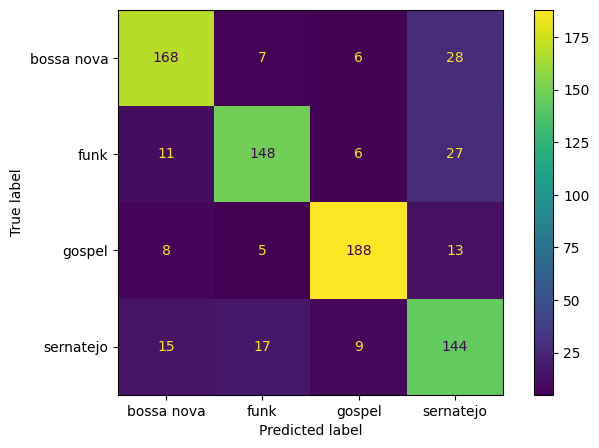

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["bossa nova", "funk", "gospel", "sernatejo"],
)

cmp.plot(ax=ax)
plt.show()

### 4.2 Random Forest

Otimização dos hiperparâmetros usando GridSearchCV

In [19]:
params_rf = {"max_depth": [20],
                "min_samples_split": [5, 10],
                "max_leaf_nodes": [175, 200],
                "min_samples_leaf": [5, 10, 50],
                "n_estimators": [250, 300, 500],
                "max_features": ["sqrt", 4],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train, y_train)
rf = rf_cv.best_estimator_

              precision    recall  f1-score   support

  Bossa Nova       0.87      0.81      0.84       209
        Funk       0.89      0.78      0.83       192
      Gospel       0.89      0.91      0.90       214
   Sertanejo       0.71      0.83      0.76       185

    accuracy                           0.83       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.83      0.84       800



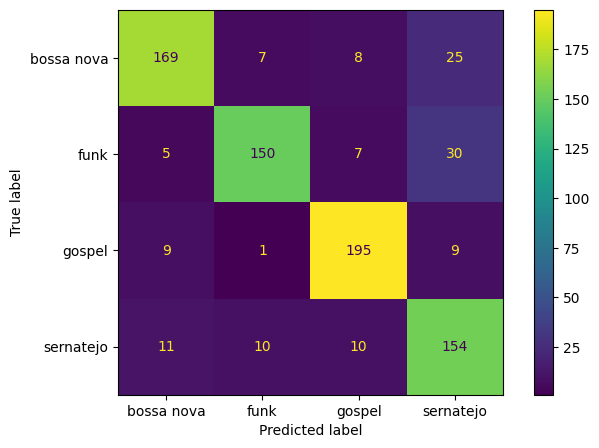

In [22]:
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred, target_names=["Bossa Nova", "Funk", "Gospel", "Sertanejo"]))

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["bossa nova", "funk", "gospel", "sernatejo"],
)

cmp.plot(ax=ax)
plt.show()

### 4.3 SVM

Otimização dos hiperparâmetros usando GridSearchCV

In [23]:
svc = SVC(random_state=1, C=10, gamma=0.001, kernel='rbf')
svc.fit(X_train, y_train)

SVC(C=10, gamma=0.001, random_state=1)

In [ ]:
#params_svc = {'C': [0.1, 1, 10], 
#              'gamma': [0.1, 0.01, 0.001],
#              'kernel': ['rbf']}

#svc = SVC(random_state=1)
#svc_cv = GridSearchCV(svc, params_svc, refit = True, verbose = 3)
#svc_cv.fit(X_train, y_train)
#svc = svc_cv.best_estimator_

              precision    recall  f1-score   support

  Bossa Nova       0.81      0.79      0.80       209
        Funk       0.81      0.78      0.79       192
      Gospel       0.90      0.86      0.88       214
   Sertanejo       0.68      0.77      0.72       185

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800



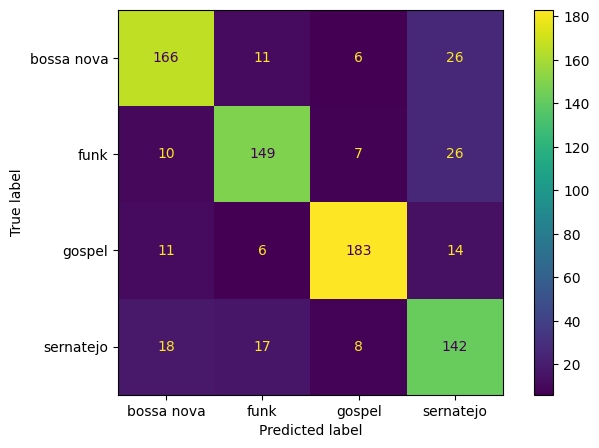

In [24]:
y_pred = svc.predict(X_test)

print(classification_report(y_test,y_pred,target_names=["Bossa Nova", "Funk", "Gospel", "Sertanejo"]))

fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
   confusion_matrix(y_test, y_pred),
   display_labels=["bossa nova", "funk", "gospel", "sernatejo"],
)

cmp.plot(ax=ax)
plt.show()

## 5. Salvando modelos e Bag of Words

In [25]:
import pickle

In [26]:
with open('models/lr_model.pkl', 'wb') as f:
    pickle.dump(lr, f)

In [27]:
with open('models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [28]:
with open('models/svc_model.pkl', 'wb') as f:
    pickle.dump(svc, f)

In [29]:
df_bow_sklearn.to_csv("bag_of_words.csv",sep=";",index=False)